In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [3]:
df = pd.read_csv("drawndata1.csv")

In [4]:
df

,x,y,z
0,58.080365,225.699042,a
1,238.867357,247.456645,a
2,156.218212,286.588782,a
3,262.004361,284.251445,a
4,185.243183,308.187571,a
...,...,...,...
247,186.111898,41.435729,a
248,53.758007,1.473481,a
249,45.915907,23.502998,a
250,110.652516,12.141801,a


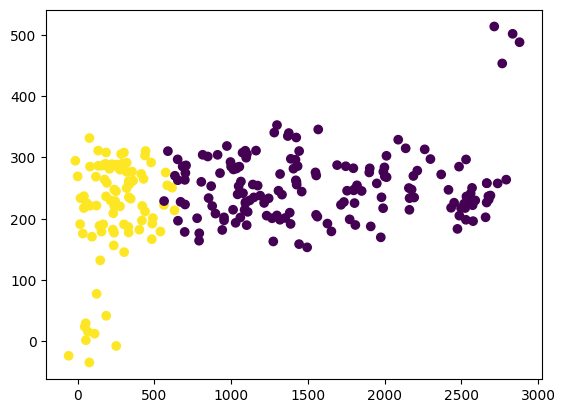

In [10]:
# Creating a scatter graph where each point has an x and y coordinate as specified in the data 
# and coloured based on if they have an a or b value.
X = df[["x", "y"]].values # This is our dataset (the coordinates) so is called X
y = df["z"] == "a" # This is what we want to predict (the a or b value) so is called y
plt.scatter(X[:, 0], X[:, 1], c=y)

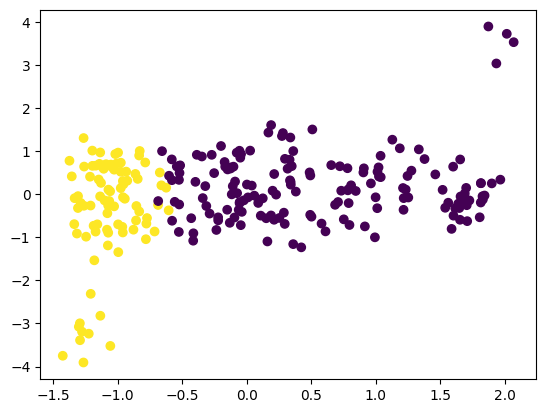

In [11]:
# We want to scale this data using StandardScaler, as currently the x and y axis are completely different scales
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y)

Note that we still have outliers above, since we are using mean and standard deviation. We can instead use quantiles (i.e. 0.25 quantile means 25% of data is to the left of that line/below this value and 75% is to the right/above this value)

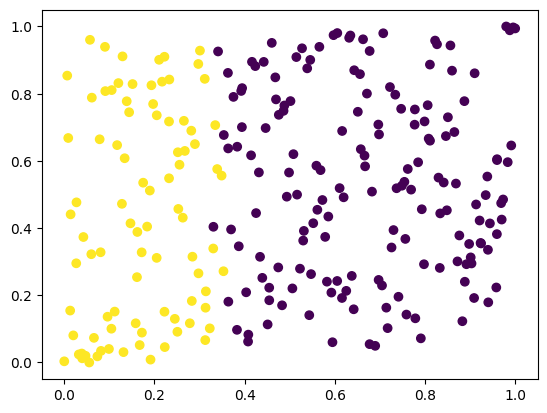

In [16]:
from sklearn.preprocessing import QuantileTransformer
X_scaled = QuantileTransformer(n_quantiles=100).fit_transform(X)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def plot_output(scaler):
    pipe = Pipeline([
        ("scale", scaler),
        ("model", KNeighborsClassifier(n_neighbors=20, weights='distance'))
    ])

    pred = pipe.fit(X, y).predict(X)

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Original Data")
    plt.subplot(132)
    X_tfm = scaler.transform(X)
    plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=y)
    plt.title("Transformed Data")
    plt.subplot(133)
    X_new = np.concatenate([
        np.random.uniform(0, X[:, 0].max(), (5000, 1)), 
        np.random.uniform(0, X[:, 1].max(), (5000, 1))
    ], axis=1)
    y_proba = pipe.predict_proba(X_new)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_proba[:, 1], alpha=0.7)
    plt.title("Predicted Data")

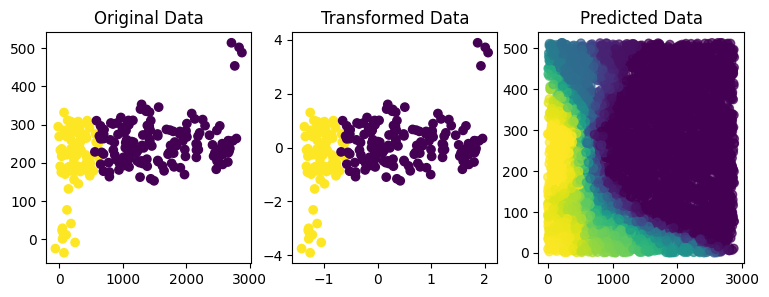

In [21]:
plot_output(scaler=StandardScaler())

Using the standard scaler we see that everything around the bottom left is predicted as yellow class (as seen in predicted data image, while around the right/top is purple class)


Since StandardScaler uses mean and standard deviation to calculate the scaling, one extreme outlier can stretch the scaling for all points, meaning the main cluster gets squashed into a small range and making classification boundaries harder to place. 

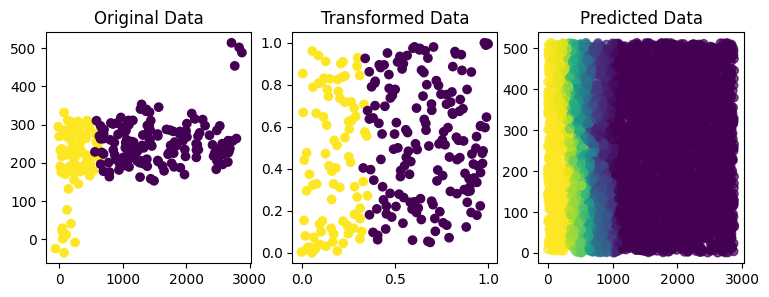

In [22]:
plot_output(scaler=QuantileTransformer(n_quantiles=100))

However, now our transformed data is less influenced by the outliers, the model now things there is a dividing line between the yellow and purple classes and that is how we will classify the class of a point.

QuantileTransformer will instead sort values and assign them a quantile rank, and these ranks are evenly spaced, meaning it doesn't matter how far an outlier is from the main bulk of values, it will just be given a rank of 1.0 instead, compressing the tails and expanding the middle of the distribution

## Example of Data that isn't Linearly Separable

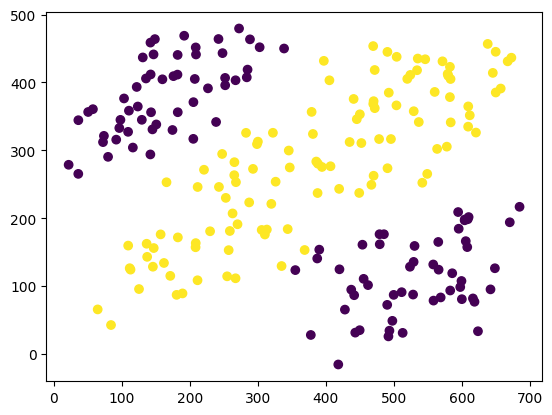

In [24]:
df = pd.read_csv("drawndata2.csv")
X = df[["x", "y"]].values # This is our dataset (the coordinates) so is called X
y = df["z"] == "a" # This is what we want to predict (the a or b value) so is called y
plt.scatter(X[:, 0], X[:, 1], c=y)

This data is is not linearly separable (i.e. we can't draw a line so that one side of the line has yellow and the other purple like the first data set)

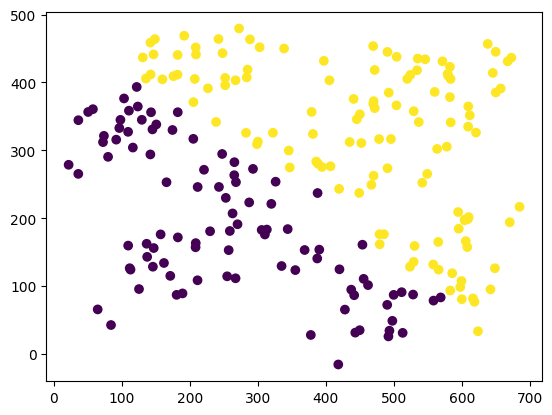

In [25]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scale", QuantileTransformer(n_quantiles=100)),
    ("model", LogisticRegression())
])

prediction = pipe.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction)

We can see from our predictions that this is a bad classifier, as the two clumps of purple seen in the data are not seen in the prediction

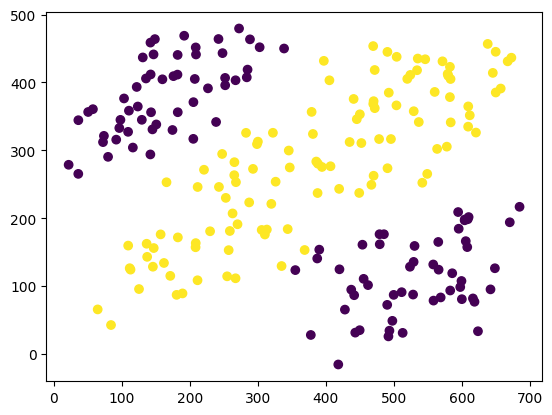

In [26]:
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([
    ("scale", PolynomialFeatures()),
    ("model", LogisticRegression())
])

prediction = pipe.fit(X, y).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction)

We can use PolynomialFeatures to create new features by taking polynomial combinations of our original features, therefore is useful when using a linear model (which we are: LogisticRegression()) but our data has non-linear relationships. 
E.g. if we have axis X1 and X2, when using LogisticRegression, this model can only use these two features to come up with a separating line - when we use PolynomialFeatures, the model can use extra features, like X1*X2, X1^2, X2^2. These extra terms allow for the linear model to represent curved, or more complex decision boundaries in the original feature space.

## Preprocessing text data to numeric data

In [39]:
arr = np.array(["low", "low", "high", "medium"]).reshape(-1, 1) # Convert into 2d array
arr

array([['low'],
       ['low'],
       ['high'],
       ['medium']], dtype='<U6')

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit_transform(arr)
# Low is middle column, high is left column, medium is right column (value of 1)

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [46]:
encoder.transform([["zero"]]) # Since in the constructor handle_unknown is ignore, we can give a label to this new unknown value

array([[0., 0., 0.]])

This above result means that zero is neither low, high or medium